## Importing required libraries

In [1]:
import cv2
import copy
import numpy as np
from PIL import Image
from crf import apply_crf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms.functional as F
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(str(device) + ' is selected !')

cuda is selected !


## MDA-Net architecture with Multiscale fusion and Dual attention mechanism

In [2]:
## Dual Attention block

class dualAttention(nn.Module):
    def __init__(self, F_g, F_l, F_int, ratio=2):
        super(dualAttention,self).__init__()

        self.conv = nn.Conv2d(F_g, F_l, 1, bias=True)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc11 = nn.Conv2d(F_l, F_l // ratio, 1, bias=True)
        self.fc12 = nn.Conv2d(F_l // ratio, F_l, 1, bias=True)

        self.fc21 = nn.Conv2d(F_l, F_l // ratio, 1, bias=True)
        self.fc22 = nn.Conv2d(F_l // ratio, F_l, 1, bias=True)

        self.LeakyReLU = nn.LeakyReLU(inplace=True)

        self.sigmoid = nn.Sigmoid()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid(),
        )

    def forward(self, g, x):

        x1 = self.conv(x)

        avg_out = self.fc12(self.LeakyReLU(self.fc11(self.avg_pool(x1))))
        max_out = self.fc22(self.LeakyReLU(self.fc21(self.max_pool(x1))))

        out = avg_out + max_out

        del avg_out, max_out

        x1 = x1 * self.sigmoid(out)

        g1 = self.W_g(g)
        x2 = self.W_x(x1)

        leakyReLU = self.LeakyReLU(g1 + x2)
        psi = self.psi(leakyReLU)

        return x * psi

## 1x1 Conv block

class conv_block_1(nn.Module):

    def __init__(self, ch_in, ch_out):
        super(conv_block_1, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

## 3x3 Conv block

class conv_block_3(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(conv_block_3, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

## 5x5 Conv block

class conv_block_5(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(conv_block_5, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=5, stride=1, padding=2, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=5, stride=1, padding=2, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


## Multiscale fusion block

class conv_3_1(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(conv_3_1, self).__init__()
        self.conv_1 = conv_block_1(ch_in, ch_out)
        self.conv_3 = conv_block_3(ch_in, ch_out)
        self.conv_5 = conv_block_5(ch_in, ch_out)
        self.conv = nn.Conv2d(ch_out * 3, ch_out, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        x1 = self.conv_1(x)
        x3 = self.conv_3(x)
        x5 = self.conv_5(x)
        x = torch.cat((x1, x3, x5), dim=1)

        x = self.conv(x)
        return x

class up_conv(nn.Module):

    def __init__(self, ch_in, ch_out, bilinear=False):
        super(up_conv, self).__init__()
        if bilinear:
            self.up = nn.Sequential(
                nn.UplAmple(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(ch_in, ch_in, kernel_size=3, stride=1, padding=1, bias=True),
                nn.BatchNorm2d(ch_in),
                nn.ReLU(inplace=True)
            )
        else:
            self.up = nn.ConvTranspose2d(ch_in, ch_out, kernel_size=2, stride=2)

    def forward(self, x):
        x = self.up(x)
        return x

## Proposed MDA_Net for BUS segmentation

class MDA_Net(nn.Module):
    def __init__(self, img_ch=1, output_ch=1):
        super(MDA_Net, self).__init__()

        filters_number = [32, 64, 128, 256, 512]

        self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_3_1(ch_in=img_ch, ch_out=filters_number[0])
        self.Conv2 = conv_3_1(ch_in=filters_number[0], ch_out=filters_number[1])
        self.Conv3 = conv_3_1(ch_in=filters_number[1], ch_out=filters_number[2])
        self.Conv4 = conv_3_1(ch_in=filters_number[2], ch_out=filters_number[3])
        self.Conv5 = conv_3_1(ch_in=filters_number[3], ch_out=filters_number[4])

        self.Up5 = up_conv(ch_in=filters_number[4], ch_out=filters_number[3])
        self.dA51 = dualAttention(F_g=filters_number[3], F_l=filters_number[3], F_int=filters_number[2])
        self.Up_conv5 = conv_3_1(ch_in=filters_number[4], ch_out=filters_number[3])

        self.Up4 = up_conv(ch_in=filters_number[3], ch_out=filters_number[2])
        self.dA41 = dualAttention(F_g=filters_number[2], F_l=filters_number[2], F_int=filters_number[1])
        self.Up_conv4 = conv_3_1(ch_in=filters_number[3], ch_out=filters_number[2])

        self.Up3 = up_conv(ch_in=filters_number[2], ch_out=filters_number[1])
        self.dA31 = dualAttention(F_g=filters_number[1], F_l=filters_number[1], F_int=filters_number[0])
        self.Up_conv3 = conv_3_1(ch_in=filters_number[2], ch_out=filters_number[1])

        self.Up2 = up_conv(ch_in=filters_number[1], ch_out=filters_number[0])
        self.dA21 = dualAttention(F_g=filters_number[0], F_l=filters_number[0], F_int=16)
        self.Up_conv2 = conv_3_1(ch_in=filters_number[1], ch_out=filters_number[0])

        self.Conv_1x1 = nn.Conv2d(filters_number[0], output_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)

        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4= self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        d5 = self.Up5(x5)
        x41 = self.dA51(d5, x4)
        d5 = torch.cat((x41, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x31 = self.dA41(d4, x3)
        d4 = torch.cat((x31, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x21 = self.dA31(d3, x2)
        d3 = torch.cat((x21, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x11 = self.dA21(d2, x1)
        d2 = torch.cat((x11, d2), dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

## Visualize Model

In [3]:
model = MDA_Net().cuda()

summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]              64
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           1,056
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              ReLU-6         [-1, 32, 128, 128]               0
      conv_block_1-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 32, 128, 128]             320
       BatchNorm2d-9         [-1, 32, 128, 128]              64
             ReLU-10         [-1, 32, 128, 128]               0
           Conv2d-11         [-1, 32, 128, 128]           9,248
      BatchNorm2d-12         [-1, 32, 128, 128]              64
             ReLU-13         [-1, 32, 128, 128]               0
     conv_block_3-14         [-1, 32, 1

# Dataset

In [4]:
## Private - Test : 0350, 01710, 03220

data = 'test_images/'

img  = '01710_img.png'
msk  = '01710_msk.png'

## Image
image = cv2.imread(data + img, cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (128, 128))
ori_img1 = image

image1 = np.expand_dims(image, axis=0) ## For Grey Image
image1 = image1/255.0
image1 = np.expand_dims(image1, axis=0)
image1 = image1.astype(np.float32)
image1 = torch.from_numpy(image1)
image1 = image1.to(device)

## Mask
mask = cv2.imread(data + msk, cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, (128, 128))
ori_mask1 = mask
mask1 = np.expand_dims(mask, axis=0)
mask1 = mask1/255.0
mask1 = np.expand_dims(mask1, axis=0)
mask1 = mask1.astype(np.uint8)

# Shape
print('image shape:', image1.shape, 'roi shape:', mask1.shape)

image shape: torch.Size([1, 1, 128, 128]) roi shape: (1, 1, 128, 128)


# Load pretrained weight

In [6]:
## Please download pretrained weight: https://drive.google.com/file/d/1x73MYu1fYgEA0-Bu2leNbDtI-t_SKFJr

model = model.to(device)
model.load_state_dict(torch.load('MDA-Net_weight.pth', map_location=device))
model.eval()

with torch.no_grad():
    
    pred_y1 = torch.sigmoid(model(image1))
    pred_y1 = pred_y1.cpu().numpy()
    
    y_pred = pred_y1 > 0.5
    y_pred = y_pred.reshape(-1)
    y_pred = y_pred.astype(np.uint8)
    
    trueY   = mask1
    y_true = trueY > 0.5
    y_true = y_true.reshape(-1)
    y_true = y_true.astype(np.uint8)
    
    score_f1 = f1_score(y_true, y_pred, average='binary')
    
    print("Dice : "+ str(score_f1))
    
    """ Predicted Mask """
    y_pred = pred_y1
    y_pred = y_pred > 0.5
    y_pred = y_pred.reshape(-1)
    y_pred = y_pred.astype(np.uint8)
    y_pred = apply_crf(ori_img1, y_pred)
    y_pred = y_pred * 255
    y_pred = np.array(y_pred, dtype=np.uint8)

Dice : 0.9608294930875576


# Plot Prediction

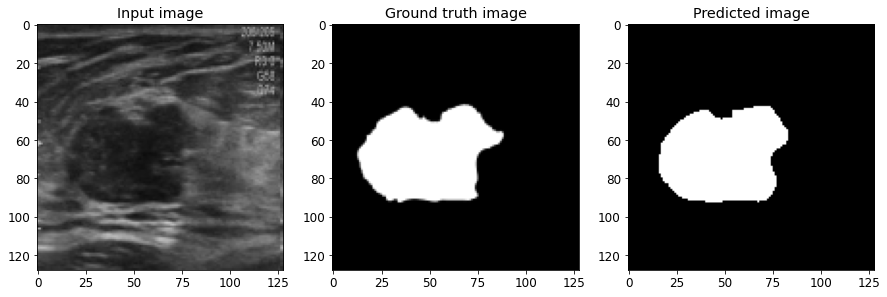

In [7]:
plt.rcParams["figure.figsize"] = (15, 15)
plt.rc('font', size=12)
plt.figure()
plt.subplot(131)
plt.title('Input image')
plt.imshow(cv2.cvtColor(ori_img1, cv2.COLOR_BGR2RGB))
plt.subplot(132)
plt.title('Ground truth image')
plt.imshow(ori_mask1, cmap='gray')
plt.subplot(133)
plt.imshow(y_pred, cmap='gray')
plt.title('Predicted image')
plt.show()

# Plot Contour

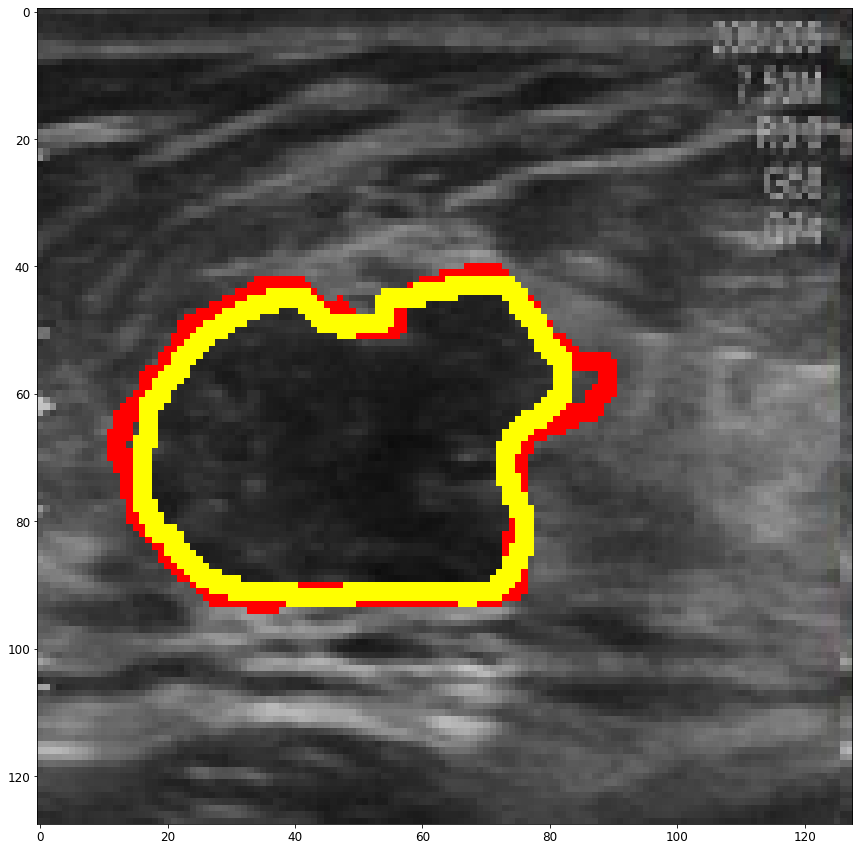

In [9]:
img_org = cv2.imread(data + img, cv2.IMREAD_COLOR)
img_org = cv2.resize(img_org, (128, 128))

contours, hierarchy = cv2.findContours(ori_mask1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cv2.drawContours(img_org, contours, 0, (0, 0, 255), 2) ## For the True ROI (Red color)

contours, hierarchy = cv2.findContours(y_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cv2.drawContours(img_org, contours, 0, (0, 255, 255), 2) ## For the predicted ROI (Yellow color)

## Display image
plt.imshow(cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB))